In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import functional as F_T
from torchvision.models import vgg19, VGG19_Weights
from PIL.Image import open
import matplotlib.pyplot as plt

device = torch.device('cuda')

In [2]:
def load_image(image_name):
    image = F_T.to_tensor(open(image_name)).unsqueeze(0)
    return image.to(device)

def show_image(tensor):
    img = F_T.to_pil_image(tensor.squeeze(0))
    plt.imshow(img)

In [3]:
class LossLayer(nn.Module):
    def __init__(self, target, mode='style'):
        super().__init__()
        self.target = target.detach()
        self.mode = mode
        if mode == 'style':
            self.target = LossLayer.get_gram_matrix(self.target)
    
    def forward(self, x):
        x_ = LossLayer.get_gram_matrix(x) if self.mode == 'style' else x
        self.loss = F.mse_loss(x_, self.target)
        return x
    
    @staticmethod
    def get_gram_matrix(x):
        x_flattened = x.reshape(x.shape[1], -1)
        gram_matrix = torch.matmul(x_flattened, x_flattened.transpose(0, 1))
        return gram_matrix / (x_flattened.shape[0] * x_flattened.shape[1])

In [4]:
SIMPLE_NAME = {
    'Conv2d': 'conv_{}',
    'ReLU': 'relu_{}',
    'MaxPool2d': 'pool_{}'
}

In [5]:
def get_model_and_loss_layers(net, style_image, content_image,
               content_layers=['conv_4'],
               style_layers=[f'conv_{i}' for i in range(1, 6)]):
    content_loss_layers, style_loss_layers = [], []
    model = nn.Sequential()
    conv_count, num_of_last_loss_layer = 0, None
    for i, layer in enumerate(net.children()):
        name = SIMPLE_NAME[str(layer).split('(')[0]]
        if name == 'conv_{}':
            conv_count += 1
        if name == 'relu_{}':
            layer = nn.ReLU()
        name = name.format(conv_count)
        model.add_module(name, layer)
        if name in content_layers:
            target = model(content_image).detach()
            content_loss = LossLayer(target, mode='content')
            model.add_module('content_loss_{}'.format(conv_count), content_loss)
            content_loss_layers.append(content_loss)
            num_of_last_loss_layer = i + 1
        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = LossLayer(target_feature, mode='style')
            model.add_module('style_loss_{}'.format(conv_count), style_loss)
            style_loss_layers.append(style_loss)
            num_of_last_loss_layer = i + 1
    return model[:i], content_loss_layers, style_loss_layers

In [6]:
def style_transfer(net, content_image, style_image, input_image, iterations=100000, optimizer=Adam,
                   lr=0.1, scheduler=StepLR, style_weight=1000000000, content_weight=1):
    model, content_loss_layers, style_loss_layers = get_model_and_loss_layers(net,
                                                                              style_image, content_image)
    input_image.requires_grad = True
    model.requires_grad = False
    optimizer = optimizer([input_image], lr=lr)
    scheduler = scheduler(optimizer, step_size=100, gamma=0.985)
    for i in range(iterations):
        def closure():
            optimizer.zero_grad()
            model(input_image)
            content_loss, style_loss = 0, 0
            for content_loss_layer in content_loss_layers:
                content_loss += content_loss_layer.loss
            for style_loss_layer in style_loss_layers:
                style_loss += style_loss_layer.loss
            content_loss *= content_weight / len(content_loss_layers)
            style_loss *= style_weight / len(style_loss_layers)
            loss = content_loss + style_loss
            if (i + 1) % 100 == 0:
                pattern = 'Iteration: {} \t| Content Loss: {} \t| Style Loss: {} \t| Total Loss: {}'
                print(pattern.format(i + 1, content_loss.item(), style_loss.item(), loss.item()))
            loss.backward()
        optimizer.step(closure)
        scheduler.step()
    return input_image.clamp(0, 1).detach()

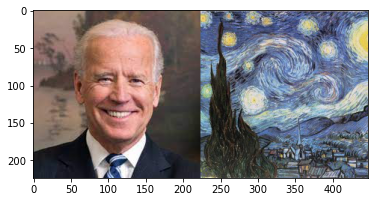

In [7]:
vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

content_image = load_image('content_image.jpg')
style_image = load_image('style_image.jpg')
input_image = content_image.clone()

show_image(torch.cat((content_image, style_image), dim=3))

In [8]:
output_image = style_transfer(vgg, content_image, style_image, input_image)

Iteration: 100 	| Content Loss: 4.805389404296875 	| Style Loss: 369.8820495605469 	| Total Loss: 374.68743896484375
Iteration: 200 	| Content Loss: 4.877037525177002 	| Style Loss: 67.65157318115234 	| Total Loss: 72.52861022949219
Iteration: 300 	| Content Loss: 4.9115071296691895 	| Style Loss: 31.274044036865234 	| Total Loss: 36.185550689697266
Iteration: 400 	| Content Loss: 4.924323081970215 	| Style Loss: 21.54262924194336 	| Total Loss: 26.46695327758789
Iteration: 500 	| Content Loss: 4.922807216644287 	| Style Loss: 20.653718948364258 	| Total Loss: 25.576526641845703
Iteration: 600 	| Content Loss: 10.037145614624023 	| Style Loss: 350853.34375 	| Total Loss: 350863.375
Iteration: 700 	| Content Loss: 5.684985160827637 	| Style Loss: 1137.661865234375 	| Total Loss: 1143.3468017578125
Iteration: 800 	| Content Loss: 5.694014549255371 	| Style Loss: 432.76123046875 	| Total Loss: 438.4552307128906
Iteration: 900 	| Content Loss: 5.704591751098633 	| Style Loss: 240.360717773

Iteration: 7100 	| Content Loss: 5.869086265563965 	| Style Loss: 6.530642509460449 	| Total Loss: 12.399728775024414
Iteration: 7200 	| Content Loss: 5.861443996429443 	| Style Loss: 6.331840991973877 	| Total Loss: 12.19328498840332
Iteration: 7300 	| Content Loss: 5.849292755126953 	| Style Loss: 7.041990756988525 	| Total Loss: 12.89128303527832
Iteration: 7400 	| Content Loss: 5.840385437011719 	| Style Loss: 6.730446815490723 	| Total Loss: 12.570832252502441
Iteration: 7500 	| Content Loss: 5.836607933044434 	| Style Loss: 6.385904788970947 	| Total Loss: 12.222513198852539
Iteration: 7600 	| Content Loss: 5.823256969451904 	| Style Loss: 7.628991603851318 	| Total Loss: 13.452248573303223
Iteration: 7700 	| Content Loss: 5.8183112144470215 	| Style Loss: 5.025533676147461 	| Total Loss: 10.84384536743164
Iteration: 7800 	| Content Loss: 5.8142499923706055 	| Style Loss: 6.142818927764893 	| Total Loss: 11.957069396972656
Iteration: 7900 	| Content Loss: 5.820283889770508 	| Sty

Iteration: 14100 	| Content Loss: 5.720315456390381 	| Style Loss: 3.214770555496216 	| Total Loss: 8.935086250305176
Iteration: 14200 	| Content Loss: 5.719453811645508 	| Style Loss: 31.173351287841797 	| Total Loss: 36.89280700683594
Iteration: 14300 	| Content Loss: 5.695384502410889 	| Style Loss: 16.90943145751953 	| Total Loss: 22.604816436767578
Iteration: 14400 	| Content Loss: 5.672359943389893 	| Style Loss: 2.5604865550994873 	| Total Loss: 8.2328462600708
Iteration: 14500 	| Content Loss: 5.734164237976074 	| Style Loss: 48.76875305175781 	| Total Loss: 54.5029182434082
Iteration: 14600 	| Content Loss: 5.731583595275879 	| Style Loss: 8.183542251586914 	| Total Loss: 13.915125846862793
Iteration: 14700 	| Content Loss: 5.715020656585693 	| Style Loss: 4.663812160491943 	| Total Loss: 10.378832817077637
Iteration: 14800 	| Content Loss: 5.700638771057129 	| Style Loss: 5.673944473266602 	| Total Loss: 11.37458324432373
Iteration: 14900 	| Content Loss: 5.673872947692871 	|

Iteration: 21100 	| Content Loss: 5.030549049377441 	| Style Loss: 0.9093669056892395 	| Total Loss: 5.939916133880615
Iteration: 21200 	| Content Loss: 5.023526191711426 	| Style Loss: 3.3455684185028076 	| Total Loss: 8.369094848632812
Iteration: 21300 	| Content Loss: 5.00706148147583 	| Style Loss: 3.6461493968963623 	| Total Loss: 8.653210639953613
Iteration: 21400 	| Content Loss: 5.002195358276367 	| Style Loss: 0.889146625995636 	| Total Loss: 5.8913421630859375
Iteration: 21500 	| Content Loss: 4.996243953704834 	| Style Loss: 0.957661509513855 	| Total Loss: 5.9539055824279785
Iteration: 21600 	| Content Loss: 4.987661838531494 	| Style Loss: 2.316664218902588 	| Total Loss: 7.304326057434082
Iteration: 21700 	| Content Loss: 4.976841449737549 	| Style Loss: 0.8563684821128845 	| Total Loss: 5.833209991455078
Iteration: 21800 	| Content Loss: 4.968775749206543 	| Style Loss: 3.5621042251586914 	| Total Loss: 8.530879974365234
Iteration: 21900 	| Content Loss: 4.95949983596801

Iteration: 28000 	| Content Loss: 4.6000494956970215 	| Style Loss: 0.5554196238517761 	| Total Loss: 5.155468940734863
Iteration: 28100 	| Content Loss: 4.597076416015625 	| Style Loss: 0.5506294369697571 	| Total Loss: 5.147706031799316
Iteration: 28200 	| Content Loss: 4.592526912689209 	| Style Loss: 1.3119890689849854 	| Total Loss: 5.904516220092773
Iteration: 28300 	| Content Loss: 4.588306903839111 	| Style Loss: 0.5377287268638611 	| Total Loss: 5.126035690307617
Iteration: 28400 	| Content Loss: 4.583427429199219 	| Style Loss: 0.7522088885307312 	| Total Loss: 5.335636138916016
Iteration: 28500 	| Content Loss: 4.578388214111328 	| Style Loss: 0.9803411364555359 	| Total Loss: 5.55872917175293
Iteration: 28600 	| Content Loss: 4.57454776763916 	| Style Loss: 0.5380123257637024 	| Total Loss: 5.112560272216797
Iteration: 28700 	| Content Loss: 4.56981897354126 	| Style Loss: 0.573665976524353 	| Total Loss: 5.143485069274902
Iteration: 28800 	| Content Loss: 4.566429615020752

Iteration: 34900 	| Content Loss: 4.366135597229004 	| Style Loss: 0.4659789800643921 	| Total Loss: 4.8321146965026855
Iteration: 35000 	| Content Loss: 4.363593101501465 	| Style Loss: 0.43864235281944275 	| Total Loss: 4.8022356033325195
Iteration: 35100 	| Content Loss: 4.360739231109619 	| Style Loss: 0.44608184695243835 	| Total Loss: 4.806820869445801
Iteration: 35200 	| Content Loss: 4.3585286140441895 	| Style Loss: 0.44719934463500977 	| Total Loss: 4.805727958679199
Iteration: 35300 	| Content Loss: 4.355860233306885 	| Style Loss: 0.4377284348011017 	| Total Loss: 4.793588638305664
Iteration: 35400 	| Content Loss: 4.353255271911621 	| Style Loss: 0.4374973177909851 	| Total Loss: 4.790752410888672
Iteration: 35500 	| Content Loss: 4.350351810455322 	| Style Loss: 0.445922315120697 	| Total Loss: 4.796274185180664
Iteration: 35600 	| Content Loss: 4.347436428070068 	| Style Loss: 0.49079322814941406 	| Total Loss: 4.838229656219482
Iteration: 35700 	| Content Loss: 4.345163

Iteration: 41800 	| Content Loss: 4.21963357925415 	| Style Loss: 0.3980890214443207 	| Total Loss: 4.617722511291504
Iteration: 41900 	| Content Loss: 4.217953205108643 	| Style Loss: 0.396965354681015 	| Total Loss: 4.6149187088012695
Iteration: 42000 	| Content Loss: 4.216187000274658 	| Style Loss: 0.3955857753753662 	| Total Loss: 4.611772537231445
Iteration: 42100 	| Content Loss: 4.214725971221924 	| Style Loss: 0.40306273102760315 	| Total Loss: 4.617788791656494
Iteration: 42200 	| Content Loss: 4.212831497192383 	| Style Loss: 0.3957301080226898 	| Total Loss: 4.6085615158081055
Iteration: 42300 	| Content Loss: 4.211164951324463 	| Style Loss: 0.3962422311306 	| Total Loss: 4.607407093048096
Iteration: 42400 	| Content Loss: 4.209403038024902 	| Style Loss: 0.3969425559043884 	| Total Loss: 4.6063456535339355
Iteration: 42500 	| Content Loss: 4.208032608032227 	| Style Loss: 0.3974016308784485 	| Total Loss: 4.605434417724609
Iteration: 42600 	| Content Loss: 4.2063441276550

Iteration: 48700 	| Content Loss: 4.122162818908691 	| Style Loss: 0.3721041977405548 	| Total Loss: 4.494266986846924
Iteration: 48800 	| Content Loss: 4.120998859405518 	| Style Loss: 0.37261390686035156 	| Total Loss: 4.493612766265869
Iteration: 48900 	| Content Loss: 4.119988918304443 	| Style Loss: 0.3718407452106476 	| Total Loss: 4.491829872131348
Iteration: 49000 	| Content Loss: 4.118840217590332 	| Style Loss: 0.37155988812446594 	| Total Loss: 4.490400314331055
Iteration: 49100 	| Content Loss: 4.117778778076172 	| Style Loss: 0.37117376923561096 	| Total Loss: 4.48895263671875
Iteration: 49200 	| Content Loss: 4.116645336151123 	| Style Loss: 0.3714398443698883 	| Total Loss: 4.4880852699279785
Iteration: 49300 	| Content Loss: 4.115604400634766 	| Style Loss: 0.3709008991718292 	| Total Loss: 4.486505508422852
Iteration: 49400 	| Content Loss: 4.114499568939209 	| Style Loss: 0.37032753229141235 	| Total Loss: 4.484827041625977
Iteration: 49500 	| Content Loss: 4.11349773

Iteration: 55600 	| Content Loss: 4.058430194854736 	| Style Loss: 0.35704728960990906 	| Total Loss: 4.415477275848389
Iteration: 55700 	| Content Loss: 4.057727813720703 	| Style Loss: 0.3569161295890808 	| Total Loss: 4.41464376449585
Iteration: 55800 	| Content Loss: 4.057009696960449 	| Style Loss: 0.35675927996635437 	| Total Loss: 4.413768768310547
Iteration: 55900 	| Content Loss: 4.0562896728515625 	| Style Loss: 0.3566531538963318 	| Total Loss: 4.412942886352539
Iteration: 56000 	| Content Loss: 4.055543899536133 	| Style Loss: 0.35655251145362854 	| Total Loss: 4.4120965003967285
Iteration: 56100 	| Content Loss: 4.054849624633789 	| Style Loss: 0.3562540113925934 	| Total Loss: 4.41110372543335
Iteration: 56200 	| Content Loss: 4.054149627685547 	| Style Loss: 0.356093168258667 	| Total Loss: 4.410243034362793
Iteration: 56300 	| Content Loss: 4.053403377532959 	| Style Loss: 0.35610514879226685 	| Total Loss: 4.40950870513916
Iteration: 56400 	| Content Loss: 4.0527200698

Iteration: 62500 	| Content Loss: 4.019530773162842 	| Style Loss: 0.3480684161186218 	| Total Loss: 4.367599010467529
Iteration: 62600 	| Content Loss: 4.019109725952148 	| Style Loss: 0.347989559173584 	| Total Loss: 4.367099285125732
Iteration: 62700 	| Content Loss: 4.0187201499938965 	| Style Loss: 0.3478877544403076 	| Total Loss: 4.366607666015625
Iteration: 62800 	| Content Loss: 4.0183186531066895 	| Style Loss: 0.3477776348590851 	| Total Loss: 4.366096496582031
Iteration: 62900 	| Content Loss: 4.01792573928833 	| Style Loss: 0.34767046570777893 	| Total Loss: 4.365596294403076
Iteration: 63000 	| Content Loss: 4.017541408538818 	| Style Loss: 0.34758344292640686 	| Total Loss: 4.365124702453613
Iteration: 63100 	| Content Loss: 4.0171403884887695 	| Style Loss: 0.3474852442741394 	| Total Loss: 4.364625453948975
Iteration: 63200 	| Content Loss: 4.016746520996094 	| Style Loss: 0.34741050004959106 	| Total Loss: 4.364157199859619
Iteration: 63300 	| Content Loss: 4.01637125

Iteration: 69400 	| Content Loss: 3.9988598823547363 	| Style Loss: 0.3432145118713379 	| Total Loss: 4.342074394226074
Iteration: 69500 	| Content Loss: 3.9986557960510254 	| Style Loss: 0.34316036105155945 	| Total Loss: 4.341815948486328
Iteration: 69600 	| Content Loss: 3.998443603515625 	| Style Loss: 0.34313252568244934 	| Total Loss: 4.341576099395752
Iteration: 69700 	| Content Loss: 3.998239040374756 	| Style Loss: 0.3430666923522949 	| Total Loss: 4.341305732727051
Iteration: 69800 	| Content Loss: 3.998056173324585 	| Style Loss: 0.3430030941963196 	| Total Loss: 4.34105920791626
Iteration: 69900 	| Content Loss: 3.997844934463501 	| Style Loss: 0.34297066926956177 	| Total Loss: 4.340815544128418
Iteration: 70000 	| Content Loss: 3.99764347076416 	| Style Loss: 0.3429282307624817 	| Total Loss: 4.340571880340576
Iteration: 70100 	| Content Loss: 3.9974381923675537 	| Style Loss: 0.3429054319858551 	| Total Loss: 4.340343475341797
Iteration: 70200 	| Content Loss: 3.99725055

Iteration: 76300 	| Content Loss: 3.988840103149414 	| Style Loss: 0.34087032079696655 	| Total Loss: 4.329710483551025
Iteration: 76400 	| Content Loss: 3.9887421131134033 	| Style Loss: 0.34085315465927124 	| Total Loss: 4.32959508895874
Iteration: 76500 	| Content Loss: 3.9886486530303955 	| Style Loss: 0.34081482887268066 	| Total Loss: 4.329463481903076
Iteration: 76600 	| Content Loss: 3.988551378250122 	| Style Loss: 0.34080997109413147 	| Total Loss: 4.329361438751221
Iteration: 76700 	| Content Loss: 3.9884698390960693 	| Style Loss: 0.3407592475414276 	| Total Loss: 4.32922887802124
Iteration: 76800 	| Content Loss: 3.9883804321289062 	| Style Loss: 0.34074458479881287 	| Total Loss: 4.329124927520752
Iteration: 76900 	| Content Loss: 3.988274574279785 	| Style Loss: 0.34073007106781006 	| Total Loss: 4.329004764556885
Iteration: 77000 	| Content Loss: 3.9881908893585205 	| Style Loss: 0.34070467948913574 	| Total Loss: 4.328895568847656
Iteration: 77100 	| Content Loss: 3.98

Iteration: 83200 	| Content Loss: 3.9842844009399414 	| Style Loss: 0.33976489305496216 	| Total Loss: 4.324049472808838
Iteration: 83300 	| Content Loss: 3.984246015548706 	| Style Loss: 0.3397577702999115 	| Total Loss: 4.32400369644165
Iteration: 83400 	| Content Loss: 3.984201669692993 	| Style Loss: 0.339751660823822 	| Total Loss: 4.323953151702881
Iteration: 83500 	| Content Loss: 3.984163522720337 	| Style Loss: 0.33972203731536865 	| Total Loss: 4.323885440826416
Iteration: 83600 	| Content Loss: 3.9841208457946777 	| Style Loss: 0.3397177755832672 	| Total Loss: 4.323838710784912
Iteration: 83700 	| Content Loss: 3.9840784072875977 	| Style Loss: 0.33971479535102844 	| Total Loss: 4.323793411254883
Iteration: 83800 	| Content Loss: 3.984039783477783 	| Style Loss: 0.33970707654953003 	| Total Loss: 4.323746681213379
Iteration: 83900 	| Content Loss: 3.9840080738067627 	| Style Loss: 0.33969417214393616 	| Total Loss: 4.323702335357666
Iteration: 84000 	| Content Loss: 3.98396

Iteration: 90100 	| Content Loss: 3.982323169708252 	| Style Loss: 0.33929410576820374 	| Total Loss: 4.321617126464844
Iteration: 90200 	| Content Loss: 3.982306480407715 	| Style Loss: 0.33927902579307556 	| Total Loss: 4.321585655212402
Iteration: 90300 	| Content Loss: 3.9822983741760254 	| Style Loss: 0.3392699360847473 	| Total Loss: 4.321568489074707
Iteration: 90400 	| Content Loss: 3.9822709560394287 	| Style Loss: 0.3392757773399353 	| Total Loss: 4.32154655456543
Iteration: 90500 	| Content Loss: 3.982247829437256 	| Style Loss: 0.3392723798751831 	| Total Loss: 4.3215203285217285
Iteration: 90600 	| Content Loss: 3.982236862182617 	| Style Loss: 0.3392726182937622 	| Total Loss: 4.32150936126709
Iteration: 90700 	| Content Loss: 3.9822139739990234 	| Style Loss: 0.3392693102359772 	| Total Loss: 4.321483135223389
Iteration: 90800 	| Content Loss: 3.982191324234009 	| Style Loss: 0.33927661180496216 	| Total Loss: 4.321467876434326
Iteration: 90900 	| Content Loss: 3.9821789

Iteration: 97000 	| Content Loss: 3.981536388397217 	| Style Loss: 0.3390834927558899 	| Total Loss: 4.320620059967041
Iteration: 97100 	| Content Loss: 3.9815311431884766 	| Style Loss: 0.3390914499759674 	| Total Loss: 4.320622444152832
Iteration: 97200 	| Content Loss: 3.981522560119629 	| Style Loss: 0.33908578753471375 	| Total Loss: 4.320608139038086
Iteration: 97300 	| Content Loss: 3.981515645980835 	| Style Loss: 0.3390885889530182 	| Total Loss: 4.32060432434082
Iteration: 97400 	| Content Loss: 3.9815053939819336 	| Style Loss: 0.3390854001045227 	| Total Loss: 4.320590972900391
Iteration: 97500 	| Content Loss: 3.9815049171447754 	| Style Loss: 0.33908000588417053 	| Total Loss: 4.320584774017334
Iteration: 97600 	| Content Loss: 3.981499433517456 	| Style Loss: 0.3390779495239258 	| Total Loss: 4.320577621459961
Iteration: 97700 	| Content Loss: 3.981487989425659 	| Style Loss: 0.339079350233078 	| Total Loss: 4.3205671310424805
Iteration: 97800 	| Content Loss: 3.98148226

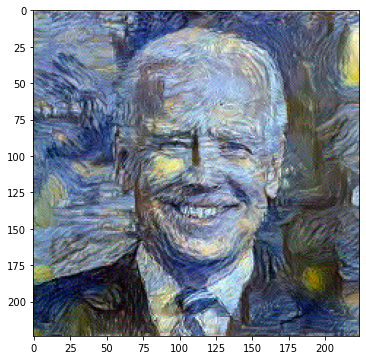

In [9]:
plt.figure(figsize=(6, 6))
show_image(output_image)